In [107]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Example 1: Single ODE

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$
 -------------------
Function: 
$$
f(x) = \cos(x) e^\frac{-x}{5} - \frac{\Psi}{5}
$$

True solution (solved by the numerical way):
$$
\Psi = e^\frac{-x}{5} \sin(x)
$$

If we have a ODE system with two ODE function => Loss function will be the sum of both

In [108]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

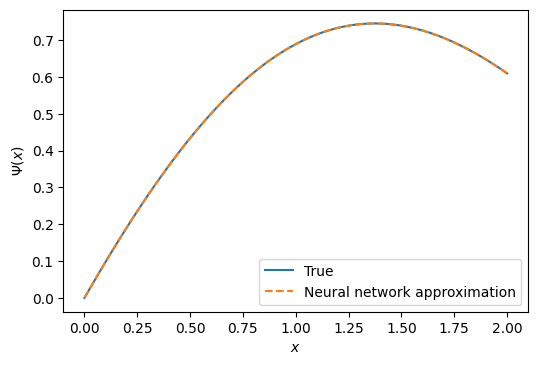

In [109]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

# Try 1 ODE with my code

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

In [37]:
# data range
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

learning_rate = 0.001
n_epoch = 500

In [3]:
# full connected network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [4]:
# N is a Neural Network - has 1 hidden layer
N = NeuralNet(1, 50, 1).to(device)

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

In [11]:
def df(nn: NeuralNet, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to the input feature(s) using PyTorch autograd engine"""
    df_value = N(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

In [39]:
# The loss function
def loss_ode(x):
    x.requires_grad = True

    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

    outputs = N(x)

    d_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]

    return torch.mean(((d_x - f(x, outputs)) ** 2) + ((N(torch.ones_like(x))-A) ** 2))

In [40]:
# Optimize
optimizer = torch.optim.Adam(N.parameters(), lr=learning_rate) 

# traning loop
for epoch in range(n_epoch):
    # forward
    l = loss_ode(x)

    # backward
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'epoch {epoch+1}, loss = {l.item():.4f}')

epoch 10, loss = 0.3680
epoch 20, loss = 0.2771
epoch 30, loss = 0.2059
epoch 40, loss = 0.1559
epoch 50, loss = 0.1200
epoch 60, loss = 0.0962
epoch 70, loss = 0.0799
epoch 80, loss = 0.0667
epoch 90, loss = 0.0578
epoch 100, loss = 0.0529
epoch 110, loss = 0.0467
epoch 120, loss = 0.0413
epoch 130, loss = 0.0385
epoch 140, loss = 0.0354
epoch 150, loss = 0.0328
epoch 160, loss = 0.0301
epoch 170, loss = 0.0281
epoch 180, loss = 0.0257
epoch 190, loss = 0.0238
epoch 200, loss = 0.0218
epoch 210, loss = 0.0199
epoch 220, loss = 0.0181
epoch 230, loss = 0.0166
epoch 240, loss = 0.0145
epoch 250, loss = 0.0131
epoch 260, loss = 0.0117
epoch 270, loss = 0.0102
epoch 280, loss = 0.0087
epoch 290, loss = 0.0072
epoch 300, loss = 0.0057
epoch 310, loss = 0.0054
epoch 320, loss = 0.0038
epoch 330, loss = 0.0036
epoch 340, loss = 0.0034
epoch 350, loss = 0.0032
epoch 360, loss = 0.0016
epoch 370, loss = 0.0015
epoch 380, loss = 0.0014
epoch 390, loss = 0.0014
epoch 400, loss = 0.0014
epoch 410

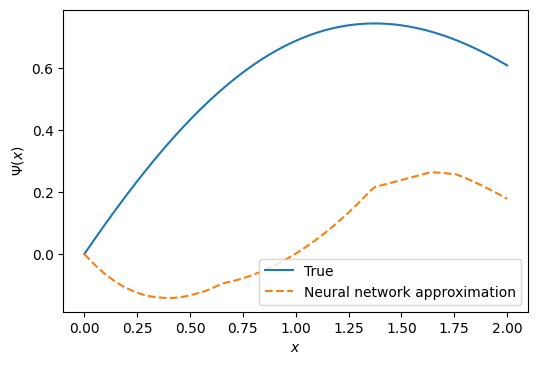

In [36]:
# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

# Try 2 ODES

Consider the ode:
$$
y_1' = y_1, \\
y_2' = y_1 - y_2,
$$

Initial Condition:
$$
y_1(0) = 1, \\
y_2(0) = 2
$$


True solution (solved by the numerical way):
$$
y_1 = e^x, \\
y_2 = \frac{1}{2}e^x + \frac{3}{2}e^{-x}
$$

In [110]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N_1 = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))
N_2 = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A_1 = 1.
A_2 = 2.

# The right hand side function
f_1 = lambda y_1: y_1
f_2 = lambda y_1, y_2: y_1 - y_2

# The loss function
def loss(x):
    x.requires_grad = True
    outputs_1 = N_1(x)
    outputs_2 = N_2(x)
    drivative_1 = torch.autograd.grad(outputs_1, x, grad_outputs=torch.ones_like(outputs_1),
                                  create_graph=True)[0]
    drivative_2 = torch.autograd.grad(outputs_2, x, grad_outputs=torch.ones_like(outputs_2),
                                  create_graph=True)[0]
    return torch.mean((drivative_1 - f_1(outputs_1)) ** 2 + (N_1(torch.zeros_like(x)) - A_1) ** 2 
                      + (drivative_2 - f_2(outputs_1, outputs_2)) ** 2 + (N_2(torch.zeros_like(x)) - A_2) ** 2)

[[-0.10636434]
 [-0.12252465]
 [-0.13855267]
 [-0.1542435 ]
 [-0.1694107 ]
 [-0.18389517]
 [-0.19757083]
 [-0.21034676]
 [-0.22216785]
 [-0.23301184]
 [-0.24288511]
 [-0.2518174 ]
 [-0.25985587]
 [-0.26706016]
 [-0.2734975 ]
 [-0.27923846]
 [-0.28435415]
 [-0.28891352]
 [-0.2929821 ]
 [-0.29662067]
 [-0.29988497]
 [-0.3028251 ]
 [-0.30548584]
 [-0.3079067 ]
 [-0.31012225]
 [-0.31216264]
 [-0.314054  ]
 [-0.31581855]
 [-0.3174755 ]
 [-0.31904095]
 [-0.32052863]
 [-0.32195023]
 [-0.32331544]
 [-0.3246321 ]
 [-0.32590717]
 [-0.32714587]
 [-0.32835296]
 [-0.32953203]
 [-0.33068612]
 [-0.33181754]
 [-0.33292818]
 [-0.33401972]
 [-0.33509314]
 [-0.33614948]
 [-0.33718944]
 [-0.33821335]
 [-0.33922186]
 [-0.3402151 ]
 [-0.34119326]
 [-0.34215647]
 [-0.3431049 ]
 [-0.34403855]
 [-0.34495735]
 [-0.3458616 ]
 [-0.34675092]
 [-0.3476256 ]
 [-0.3484856 ]
 [-0.34933087]
 [-0.35016155]
 [-0.35097766]
 [-0.35177922]
 [-0.3525664 ]
 [-0.35333908]
 [-0.3540975 ]
 [-0.35484177]
 [-0.355572  ]
 [-0.35628

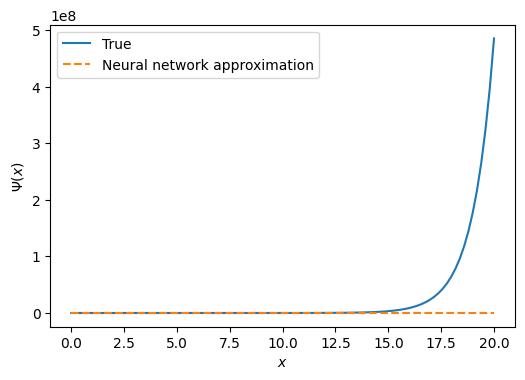

In [111]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 20, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(1000):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 20, 100)[:, None]
with torch.no_grad():
    yy = N_1(torch.Tensor(xx)).numpy()


yt = np.exp(xx)
print(yy)
print(yt)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');